In [20]:
from keras.models import Sequential
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D,MaxPooling2D,BatchNormalization
from google.colab import files
from PIL import Image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.applications import vgg19
from sklearn.utils import shuffle
import cv2
import pandas as pd
import warnings
from keras.initializers import  RandomNormal
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard

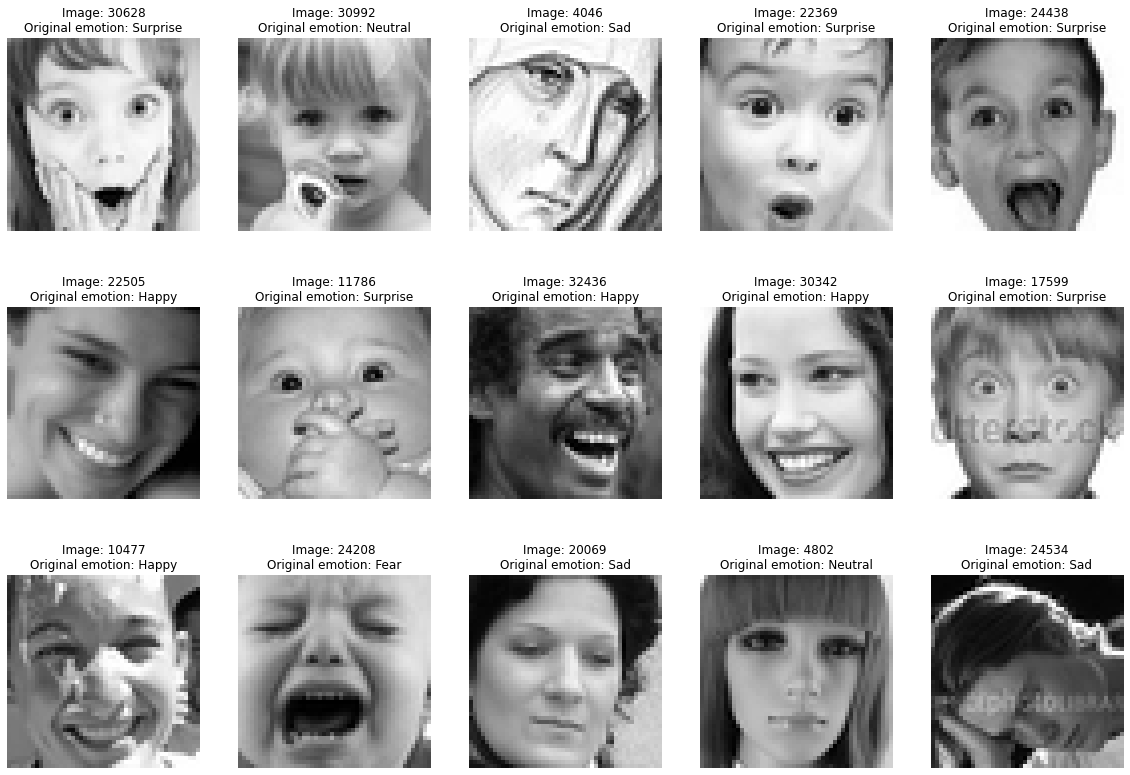

In [10]:
warnings.filterwarnings("ignore")

data = pd.read_csv('/content/fer2013.csv')

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
    """ 

    Function displaying 15 randomly chosen images. Arguments:
    
    imgs:  Source of images
    
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names. As a result, emotion name will be displayed above every image.
    
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names. As a result, emotion name will be displayed above image.
    
    random: Defult "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs) otherwise randomly chosen from values passed into "indices" argument without replacement.
    
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution. 
    
    """
    
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 15)
    else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        

show_random(images, emotion_nms_org= data['emotion_name'])


# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [13]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [14]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [17]:
model = Sequential()


model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [21]:
model.compile(loss="categorical_crossentropy",
                  optimizer='Adam',
                  metrics=['accuracy'])

In [27]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=16,
          epochs=1,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True)

1817/1817 [==============================] - 1020s 562ms/step - loss: 1.8080 - accuracy: 0.2490 - val_loss: 2.5904 - val_accuracy: 0.2632


NotImplementedError: ignored

In [33]:
imgs = Image.open(f'/content/1 (1).jpg').convert('L')
imgs=np.array(imgs)
imgs = tf.cast(imgs, tf.float32)
imgs=np.expand_dims(imgs,axis=0)
print(imgs.shape)
model.predict(imgs)


(1, 48, 48)


ValueError: ignored

In [29]:
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

full_size_image = cv2.imread("/content/1 (1).jpg")
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3  , 10)


for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

cv2.imshow('Emotion', full_size_image)
cv2.waitKey()

Image Loaded


error: ignored

https://github.com/elzawie/FER2013/blob/master/Best_model.ipynb